In [1]:
from run_classifier import *
import numpy as np
from IPython import display
import matplotlib.pyplot as plt

In [2]:
bert_config_file = 'model/uncased_L-12_H-768_A-12/bert_config.json'
train_tfrecord_fpath = '/tmp/mrpc_output/train.tf_record'
eval_tfrecord_fpath = '/tmp/mrpc_output/eval.tf_record'
is_training = True
batch_size = 32
epoch_batch_num = 100/batch_size
seq_length = 128
num_labels = 2
use_one_hot_embeddings = False
init_checkpoint = 'model/uncased_L-12_H-768_A-12/bert_model.ckpt'
learning_rate = 5e-5
num_train_steps = 100

In [3]:
bert_config = modeling.BertConfig.from_json_file(bert_config_file)
#bert_config.hidden_dropout_prob = 0.0
#bert_config.attention_probs_dropout_prob = 0.0

In [4]:
def get_dataset(train_tfrecord_fpath, is_train):
    name_to_features = {
                "input_ids_1": tf.FixedLenFeature([seq_length], tf.int64),
                "input_ids_2": tf.FixedLenFeature([seq_length], tf.int64),
                "input_mask_1": tf.FixedLenFeature([seq_length], tf.int64),
                "input_mask_2": tf.FixedLenFeature([seq_length], tf.int64),
                "label_ids": tf.FixedLenFeature([], tf.int64),
    }

    def _decode_record(record, name_to_features):
        """Decodes a record to a TensorFlow example."""
        example = tf.parse_single_example(record, name_to_features)

        # tf.Example only supports tf.int64, but the TPU only supports tf.int32.
        # So cast all int64 to int32.
        for name in list(example.keys()):
            t = example[name]
            if t.dtype == tf.int64:
                t = tf.to_int32(t)
            example[name] = t

        return example

    d = tf.data.TFRecordDataset(train_tfrecord_fpath)
    if is_train:
        d = d.repeat()
        d = d.shuffle(buffer_size=100)

    d = d.apply(
            tf.contrib.data.map_and_batch(
                    lambda record: _decode_record(record, name_to_features),
                    batch_size=batch_size
            ))
    return d

In [5]:
def read_from_file(tfrecord_fpath, is_train=False):
    d = get_dataset(tfrecord_fpath, is_train)
    handle = tf.placeholder(tf.string, shape=[])
    iterator = tf.data.Iterator.from_string_handle(handle, d.output_types, d.output_shapes)
    input_tensors = iterator.get_next()
    
    return handle, d.make_one_shot_iterator().string_handle(), input_tensors

In [6]:
def parse_input_tensors(input_tensors):
    input_ids = [input_tensors['input_ids_1'], input_tensors['input_ids_2']]
    input_mask = [input_tensors['input_mask_1'], input_tensors['input_mask_2']]
    segment_ids = None
    label_ids = input_tensors['label_ids']
    return input_ids, input_mask, segment_ids, label_ids

In [7]:
def evaluate(accuracy, feed_dict, sess, steps):
    acc = []
    for step in range(int(steps)):
        out = sess.run(accuracy, feed_dict=feed_dict)
        acc.append(out[0])

    return np.mean(acc)

In [16]:
tf.reset_default_graph()

handle, train_batch_iter, input_tensors = read_from_file(train_tfrecord_fpath, is_train=True)
_, eval_batch_iter, _ = read_from_file(eval_tfrecord_fpath, is_train=True)
input_ids, input_mask, segment_ids, label_ids = parse_input_tensors(input_tensors)

models = []
for i in range(2):
    model = modeling.BertModel(
                config=bert_config,
                is_training=is_training,
                input_ids=input_ids[i],
                input_mask=input_mask[i],
                token_type_ids=segment_ids,
                use_one_hot_embeddings=use_one_hot_embeddings)
    
    models.append(model)

hidden_size = models[0].get_pooled_output().shape[-1].value
sentence_distance = tf.squared_difference(models[0].pooled_output, models[1].pooled_output)
output_weights = tf.get_variable(
        "output_weights", [num_labels, hidden_size],
        initializer=tf.truncated_normal_initializer(stddev=0.02))

output_bias = tf.get_variable(
        "output_bias", [num_labels], initializer=tf.zeros_initializer())

dropout_keep_prob = tf.placeholder(dtype=tf.float32)
with tf.variable_scope("loss"):
    if is_training:
        # I.e., 0.1 dropout
        output_layer = tf.nn.dropout(sentence_distance, keep_prob=dropout_keep_prob)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    probabilities = tf.nn.softmax(logits, axis=-1)
    log_probs = tf.nn.log_softmax(logits, axis=-1)
    predictions = tf.argmax(logits, axis=-1, output_type=tf.int32)

    one_hot_labels = tf.one_hot(label_ids, depth=num_labels, dtype=tf.float32)

    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    
    loss = tf.reduce_mean(per_example_loss)
    
    accuracy = tf.metrics.accuracy(label_ids, predictions)
    
classificatoin_layer_vars = [output_weights, output_bias]
global_step = tf.Variable(0)
#train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss, var_list=classificatoin_layer_vars, global_step=global_step)
train_op = optimization.create_optimizer(loss, init_lr=learning_rate, num_train_steps=num_train_steps, num_warmup_steps=1, use_tpu=False, tvars=classificatoin_layer_vars)

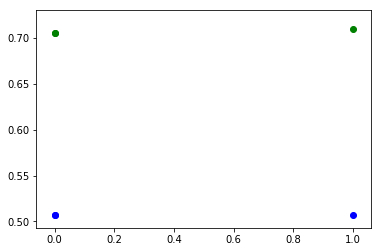

In [ ]:
metrics = {}
metrics['step'] = []
metrics['train_loss'] = []
metrics['eval_acc'] = []

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    sess.run(tf.initialize_local_variables())
    bert_vars = [var for var in tf.global_variables() if var.name.startswith('bert')]
    saver = tf.train.Saver(bert_vars)
    saver.restore(sess, init_checkpoint)
    
    train_batch = sess.run(train_batch_iter)
    eval_batch = sess.run(eval_batch_iter)
    
    for step in range(num_train_steps):
        out = sess.run([train_op, loss, accuracy], feed_dict={handle: train_batch, dropout_keep_prob: 0.9})
        train_loss = out[1]
        
        if step % 2 == 0:
            eval_acc = evaluate(accuracy, {handle: eval_batch, dropout_keep_prob: 1.0}, sess, epoch_batch_num)
            
        metrics['train_loss'].append(train_loss)
        metrics['eval_acc'].append(eval_acc)
        metrics['step'].append(step)
        
        plt.scatter(metrics['step'], metrics['train_loss'], c='g')
        plt.scatter(metrics['step'], metrics['eval_acc'], c='b')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        #metrics.to_csv('metrics/step_%d.csv'%(step))
        
        

In [15]:

metrics['train_loss']

[nan, nan, nan]